# Set up

In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [2]:
!wget https://download.pytorch.org/tutorial/faces.zip

--2019-05-15 10:12:25--  https://download.pytorch.org/tutorial/faces.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.249.134.62, 13.249.134.6, 13.249.134.52, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.249.134.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5780252 (5.5M) [application/zip]
Saving to: ‘faces.zip’

faces.zip           100%[===================>]   5.51M  28.0MB/s    in 0.2s    

2019-05-15 10:12:26 (28.0 MB/s) - ‘faces.zip’ saved [5780252/5780252]



In [8]:
!mv faces_data faces
!unzip -d faces/ faces.zip 

mv: cannot stat 'faces_data': No such file or directory
Archive:  faces.zip
   creating: faces/faces/
  inflating: faces/faces/0805personali01.jpg  
  inflating: faces/faces/1084239450_e76e00b7e7.jpg  
  inflating: faces/faces/10comm-decarlo.jpg  
  inflating: faces/faces/110276240_bec305da91.jpg  
  inflating: faces/faces/1198_0_861.jpg  
  inflating: faces/faces/137341995_e7c48e9a75.jpg  
  inflating: faces/faces/1383023626_8a49e4879a.jpg  
  inflating: faces/faces/144044282_87cf3ff76e.jpg  
  inflating: faces/faces/152601997_ec6429a43c.jpg  
  inflating: faces/faces/1549040388_b99e9fa295.jpg  
  inflating: faces/faces/1878519279_f905d4f34e.jpg  
  inflating: faces/faces/2046713398_91aaa6fe1c.jpg  
  inflating: faces/faces/2173711035_dbd53b4f9f.jpg  
  inflating: faces/faces/2210514040_6b03ff2629.jpg  
  inflating: faces/faces/2322901504_08122b01ba.jpg  
  inflating: faces/faces/2327253037_66a61ea6fe.jpg  
  inflating: faces/faces/2328398005_d328a70b4c.jpg  
  inflating: faces/faces/

In [9]:
!ls faces

faces


# view data

In [10]:
csv_file = 'faces/faces/face_landmarks.csv'

landmarks_frame = pd.read_csv(csv_file)

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


In [0]:
def show_landmarks(image, landmarks):
  """show image with landmarks"""
  plt.imshow(image)
  plt.scatter(landmarks[:, 0], landmarks[:, 1], s=20, marker='.', c='g')
  plt.pause(0.001) # pause inorder to update the plots

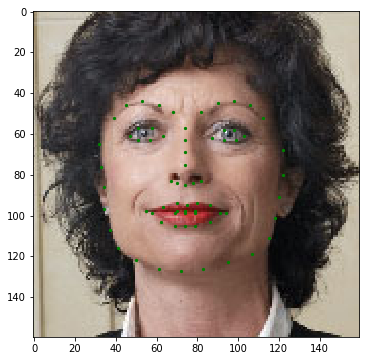

In [16]:
plt.figure(figsize=(9, 6))
show_landmarks(io.imread(os.path.join('faces/faces/', img_name)), landmarks)
plt.show()

# creating face dataset

In [0]:
class FaceLandmarksDataset(Dataset):
  """Face Landmarks dataset."""
  
  def __init__(self, csv_file, root_dir, transform=None):
    """
    args : 
          csv_file : path to the csv file with annotations.
          root_dir : directory with all images.
          transform : transformations to be applied.
    """
    self.landmarks_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  
  def __len__(self):
    return len(self.landmarks_frame)
  
  def __getitem__(self, idx):
    img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
    image = io.imread(img_name)
    landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
    landmarks = landmarks.astype('float').reshape(-1, 2)
    sample = {'image': image, 'landmarks': landmarks}
    
    if self.transform:
      sample = self.transform(sample)
    return sample

0 (324, 215, 3) (68, 2)


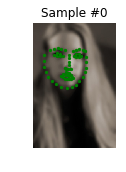

1 (500, 333, 3) (68, 2)


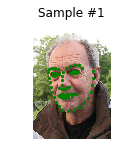

2 (250, 258, 3) (68, 2)


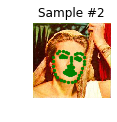

3 (434, 290, 3) (68, 2)


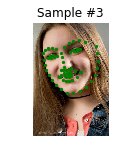

In [18]:
face_dataset = FaceLandmarksDataset(csv_file=csv_file, root_dir='faces/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
  sample = face_dataset[i]
  print(i, sample['image'].shape, sample['landmarks'].shape)
  
  ax = plt.subplot(1, 4, i + 1)
  plt.tight_layout()
  ax.set_title('Sample #{}'.format(i))
  ax.axis('off')
  show_landmarks(**sample)
  
  if i == 3:
    plt.show()
    break

# create transformations

In [0]:
class Rescale(object):
  
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size
  
  def __call__(self, sample):
    image, landmarks = sample['image'], sample['landmarks']
    
    h, w = image.shape[:2]
    if isinstance(self.output_size, int):
      if h > w:
        new_h, new_w = self.output_size * h / w, self.output_size
      else:
        new_h, new_w = self.output_size, self.output_size * w / h
    else:
      new_h, new_w = self.output_size
    new_h, new_w = int(new_h), int(new_w)
    img = transform.resize(image, (new_h, new_w))
    landmarks = landmarks * [new_w / w, new_h / h]
    return {'image': img, 'landmarks': landmarks}

In [0]:
class RandomCrop(object):
  
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    if isinstance(output_size, int):
      self.output_size = (output_size, output_size)
    else:
      assert len(output_size) == 2
      self.output_size = output_size
  
  
  def __call__(self, sample):
    image, landmarks = sample['image'], sample['landmarks']
    
    h, w = image.shape[:2]
    new_h, new_w = self.output_size
    
    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)
    
    image = image[top: top+new_h, left: left + new_w]
    landmarks = landmarks - [left, top]
    
    return {'image': image, 'landmarks': landmarks}

In [0]:
class ToTensor(object):
  
  def __call__(self, sample):
    image, landmarks = sample['image'], sample['landmarks']
    
    image = image.transpose((2, 0, 1))
    return {'image': torch.from_numpy(image), 'landmarks': torch.from_numpy(landmarks)}

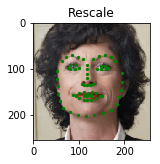

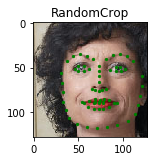

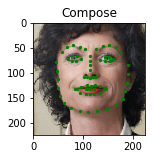

In [22]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
  transformed_sample = tsfrm(sample)
  
  ax = plt.subplot(1, 3, i + 1)
  plt.tight_layout()
  ax.set_title(type(tsfrm).__name__)
  show_landmarks(**transformed_sample)

plt.show()

In [0]:
transformed_dataset = FaceLandmarksDataset(
    csv_file=csv_file,
    root_dir='faces/faces/',
    transform=transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor()
    ])
)

# for i in range(len(transformed_dataset)):
#   sample = transformed_dataset[i]
#   print(i, sample['image'].size(), sample['landmarks'].size())
  
#   if i == 3:
#     break

In [76]:
type(transformed_dataset[0])

TypeError: ignored

In [0]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

In [0]:
def show_landmarks_batch(sample_batched):
  """Show image with landmarks for a batch of samples."""
  images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
  batch_size = len(images_batch)
  im_size = images_batch.size(2)
  
  grid = utils.make_grid(images_batch)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  
  for i in range(batch_size):
    plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size, landmarks_batch[i, :, 1].numpy(), s=10, marker='.', c='g')
    plt.title('Batch from dataloader')

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


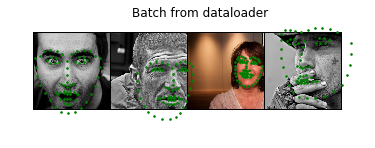

In [31]:
for i_batch, sample_batched in enumerate(dataloader):
  print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].size())
  
  if i_batch == 3:
    plt.figure()
    show_landmarks_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
    break

# build network

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(64, 64, 3)
    self.pool1 = nn.MaxPool2d(5, 5)
    self.conv2 = nn.Conv2d(64, 32, 3)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(32, 16, 3)
    self.conv4 = nn.Conv2d(16, 128, 3)
    self.fc1 = nn.Linear(128 * 3 * 3, 128)
    self.fc2 = nn.Linear(128 , 68*2)
  
  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool1(F.relu(self.conv1(x)))
    
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    
    x = x.view(-1, 128 * 3 * 3)
    x = F.sigmoid(self.fc1(x))
    x = F.sigmoid(self.fc2(x))
    return x

In [50]:
net = Net()
net

Net(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=136, bias=True)
)

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [52]:
net.to(device)

Net(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=136, bias=True)
)

In [0]:
import torch.optim as optim

In [0]:
loss = nn.MSELoss()
opt = optim.Adagrad(net.parameters(), lr=0.001, lr_decay=1e-5, weight_decay=1e-5)

In [0]:
epochs = 100

In [59]:
# for i_batch, sample_batched in enumerate(dataloader):
#   print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].size())
#   print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].view(-1, 68*2).size())
#   break


# training the network



0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
0 torch.Size([4, 3, 224, 224]) torch.Size([4, 136])


In [64]:
# 68 *2 * 4
sample_batched['landmarks'][0].size()

torch.Size([68, 2])

In [60]:
a = sample_batched['landmarks'][0].view(-1, 68*2)
a.size()

torch.Size([1, 136])

In [62]:
a.view(68, 2).size()

torch.Size([68, 2])